In [1]:
# Import required modules
from pathlib import Path
import time
import pdal
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interact
import numpy as np
import rasterio as rio
import pyhelios
from pyhelios import SimulationBuilder
from pyhelios.util import flight_planner, scene_writer

In [2]:
Path('data/scenes').mkdir(parents=True, exist_ok=True)
Path('data/sceneparts').mkdir(parents=True, exist_ok=True)
Path('data/surveys').mkdir(parents=True, exist_ok=True)

In [3]:
uls_t1 = 'data/stromboli_clipped_pre.laz'
uls_t2 = 'data/stromboli_clipped_post.laz'

uls_t1_dtm = 'data/stromboli_clipped_pre_dtm_1m.tif'
uls_t2_dtm = 'data/stromboli_clipped_post_dtm_1m.tif'

In [4]:
import laspy
import numpy as np

def inspect_laz(file):
    las = laspy.read(file)
    
    print(f"\nFile: {file}")
    print(f"Number of points: {len(las.points)}")
    print(f"Bounds:")
    print(f"  X: {las.x.min():.2f} - {las.x.max():.2f}")
    print(f"  Y: {las.y.min():.2f} - {las.y.max():.2f}")
    print(f"  Z: {las.z.min():.2f} - {las.z.max():.2f}")
    
    # Klassifikationen prüfen
    if "classification" in las.point_format.dimension_names:
        classes, counts = np.unique(las.classification, return_counts=True)
        print("Classifications:")
        for c, n in zip(classes, counts):
            print(f"  Class {c}: {n} points")
    else:
        print("No classification found.")
    
    # Mögliche Ausreißer erkennen (Z-Werte)
    z = las.z
    z_mean = np.mean(z)
    z_std = np.std(z)
    threshold = 2.5  # z. B. 1.5 Standardabweichungen
    outliers = np.sum((z < z_mean - threshold*z_std) | (z > z_mean + threshold*z_std))
    print(f"Possible outliers (based on Z, ±{threshold}σ): {outliers} points")

# Prüfe beide Dateien
for file in [uls_t1, uls_t2]:
    inspect_laz(file)



File: data/stromboli_clipped_pre.laz
Number of points: 23541446
Bounds:
  X: 517870.08 - 518815.47
  Y: 4293652.24 - 4294804.65
  Z: 298.09 - 857.57
Classifications:
  Class 0: 23541446 points
Possible outliers (based on Z, ±2.5σ): 0 points

File: data/stromboli_clipped_post.laz
Number of points: 27467148
Bounds:
  X: 517869.99 - 518815.40
  Y: 4293652.15 - 4294804.63
  Z: 298.15 - 858.11
Classifications:
  Class 0: 27467148 points
Possible outliers (based on Z, ±2.5σ): 0 points


**1.1 Create raster from ULS 2020:**

In [5]:
uls_t1_dtm = uls_t1.replace('.laz', '_dtm_1m.tif')

In [6]:
json_dtm = """[
    "%s",
    {
        "type": "filters.reprojection",
        "out_srs": "EPSG:32633"
    },
    {
        "type": "writers.gdal",
        "filename": "%s",
        "gdaldriver": "GTiff",
        "resolution": 1.0,
        "output_type": "idw",
        "window_size": 8,
        "nodata": -9999
    }
]""" % (uls_t1, uls_t1_dtm)


In [7]:
pipeline = pdal.Pipeline(json_dtm)
exe = pipeline.execute()

*1.1.1 Getting raster dimensions:*

For this we will use the python package [rasterio](https://pypi.org/project/rasterio/), which allows us to read and write TIF files.

In [4]:
# getting raster dimensions so the dimensions of the second raster can be adapted accordingly

with rio.open(uls_t1_dtm) as src:
    uls_t1_data = src.read(1, masked=True)
    t1_tf = src.transform
    t1_bounds = src.bounds
    dsm_meta = src.profile
    width= src.width
    height = src.height
    
origin_left, origin_bottom, origin_right, origin_top = t1_bounds
dsm_width = dsm_meta['width']
dsm_height = dsm_meta['height']

**1.2 Create raster from ULS 2021:**

In [9]:
uls_t2_dtm = uls_t2.replace('.laz', '_dtm_1m.tif')

In [10]:
json_dtm = """[
    "%s",
    {
        "type": "filters.reprojection",
        "out_srs": "EPSG:32633"
    },
    {
        "type": "writers.gdal",
        "filename": "%s",
        "gdaldriver": "GTiff",
        "resolution": 1.0,
        "output_type": "idw",
        "window_size": 8,
        "nodata": -9999,
        "origin_x": %.3f,
        "origin_y": %.3f,
        "width": %i,
        "height": %i
    }
]""" % (uls_t2, uls_t2_dtm, origin_left, origin_bottom, dsm_width, dsm_height)


In [11]:
pipeline = pdal.Pipeline(json_dtm)
exe = pipeline.execute()

**1.3 Calculate difference of rasters:**


In [5]:
with rio.open(uls_t1_dtm) as src:
    uls_t1_data = src.read(1, masked=True)
    
with rio.open(uls_t2_dtm) as src:
    uls_t2_data = src.read(1, masked=True)

In [6]:
uls_diff = uls_t2_data - uls_t1_data

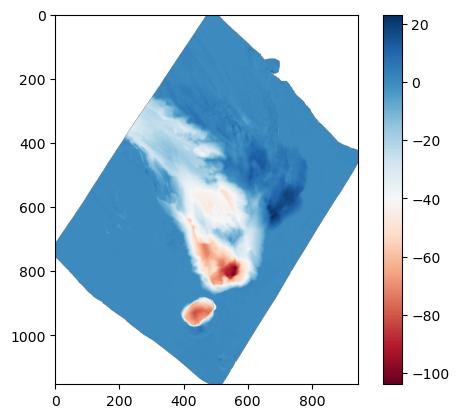

In [7]:
plt.imshow(uls_diff, cmap='RdBu')
plt.colorbar()
plt.show()

In [8]:
print(f'Standard deviation of ULS surface change: {np.nanstd(uls_diff):.3f} m')
print("DoD statistics (ignoring NaNs):")
print(f"Min change: {np.nanmin(uls_diff):.3f} m")
print(f"Max change: {np.nanmax(uls_diff):.3f} m")
print(f"Mean change: {np.nanmean(uls_diff):.3f} m")
print(f"Median change: {np.nanmedian(uls_diff):.3f} m")
print(f"Std deviation: {np.nanstd(uls_diff):.3f} m")
print(f"Absolute mean change: {np.nanmean(np.abs(uls_diff)):.3f} m")
print(f"RMS of change: {np.sqrt(np.nanmean(uls_diff**2)):.3f} m")


Standard deviation of ULS surface change: 15.955 m
DoD statistics (ignoring NaNs):
Min change: -103.861 m
Max change: 23.145 m
Mean change: -6.378 m
Median change: -36.072 m
Std deviation: 15.955 m
Absolute mean change: 8.061 m
RMS of change: 17.182 m


c:\Users\Nutzer\miniforge3\envs\3D_analysis_norcia\Lib\site-packages\numpy\_core\fromnumeric.py:867: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [9]:
uls_diff_file = 'uls_diff.tif'

with rio.open(uls_diff_file, 'w', **dsm_meta) as ff:
    ff.write(uls_diff, 1)

In [10]:
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.features import geometry_mask

# --- 1. Lade dein DoD Raster ---
with rasterio.open(uls_diff_file) as src:
    dod = src.read(1)   # 2D Array
    profile = src.profile

# --- 2. Lade dein Polygon-Shapefile ---
gdf = gpd.read_file("data/stable_parts.shp")
gdf = gdf.to_crs(profile["crs"])   # sicherstellen, dass CRS übereinstimmt

# --- 3. Maske erzeugen ---
mask = geometry_mask(gdf.geometry, transform=profile["transform"],
                     invert=True, out_shape=(src.height, src.width))

# --- 4. Stable-Bereich extrahieren ---
stable_values = dod[mask]   # nur Pixel innerhalb der Polygone
stable_std = np.nanstd(stable_values)
lod = 1.96 * stable_std

print(f"Stable Std: {stable_std:.3f} m")
print(f"Estimated LoD: {lod:.3f} m")

stable_mean = np.nanmean(stable_values)
stable_median = np.nanmedian(stable_values)

print(f"Stable Mean: {stable_mean:.3f} m")
print(f"Stable Median: {stable_median:.3f} m")



Stable Std: 0.092 m
Estimated LoD: 0.180 m
Stable Mean: 0.186 m
Stable Median: 0.173 m


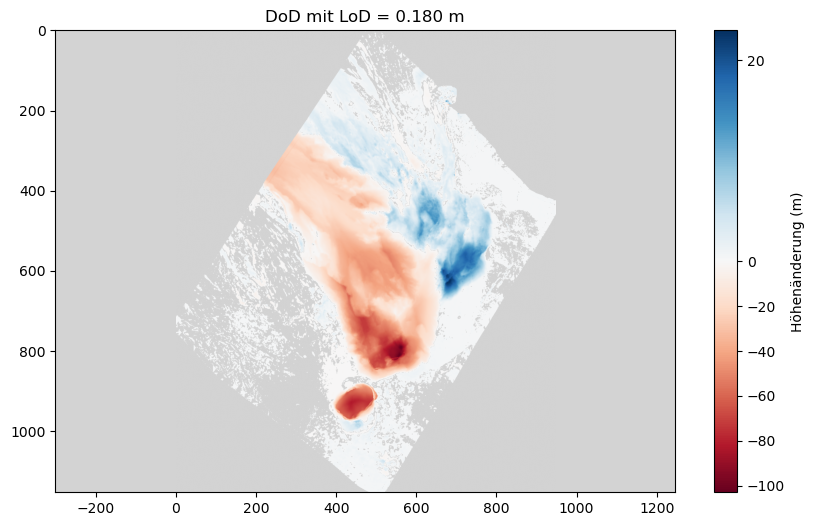

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

lod = 0.180  # LoD in Metern

# Maske für Werte unterhalb der LoD
mask = np.abs(uls_diff) < lod

# Maskierte Version für Plot
masked_diff = np.ma.array(uls_diff, mask=mask)

# Colormap kopieren und maskierte Werte auf hellgrau setzen
cmap = plt.cm.RdBu.copy()
cmap.set_bad(color='lightgrey')  # Werte unter LoD werden grau

plt.figure(figsize=(10,6))
ax = plt.gca()
ax.set_facecolor('lightgrey')  # Hintergrund grau

# Symmetrische Farbskala um 0
max_abs = np.nanmax(np.abs(uls_diff))
norm = mcolors.TwoSlopeNorm(vmin=-103, vcenter=0, vmax=23)

# Plotten
im = ax.imshow(masked_diff, cmap=cmap, norm=norm, origin='upper')
plt.colorbar(im, label='Höhenänderung (m)')
plt.title(f'DoD mit LoD = {lod:.3f} m')
plt.axis('equal')
plt.show()


In [12]:
path_mtl = 'data/sceneparts/ground.mtl'

mtl_content = """# Blender MTL File: 'None'
# Material Count: 1

newmtl terrain
Ns 0
Kd 0.2 0.5 0.2
d 1
illum 2
helios_isGround true"""

with open(path_mtl, 'w') as mtl_file:
    mtl_file.write(mtl_content)

In [20]:
sp1 = scene_writer.create_scenepart_tiff(uls_t1_dtm,
                               matfile=path_mtl,
                               matname='terrain')

sp2 = scene_writer.create_scenepart_tiff(uls_t2_dtm,
                               matfile=path_mtl,
                               matname='terrain')

<details>
    <summary>Solution</summary>
  
```python
sp1 = scene_writer.create_scenepart_tiff(uls_t1_dtm,
                               matfile=path_mtl,
                               matname='terrain')

sp2 = scene_writer.create_scenepart_tiff(uls_t2_dtm,
                               matfile=path_mtl,
                               matname='terrain')
```
</details>

*2.1.2 Build scenes*

Next, we build our two scenes. Each scene contains one of the sceneparts created in the previous step, corresponding to the rock glacier in 2020 and 2021. The `build_scene` function allows us to do so. Click the solution below if you need help.

In [21]:
scenes = [scene_writer.build_scene(scene_id='uls_t1', name='Rock Glacier T1', sceneparts=[sp1]), 
          scene_writer.build_scene(scene_id='uls_t2', name='Rock Glacier T2', sceneparts=[sp2])]

<details>
    <summary>Solution</summary>
  
```python
scenes = [scene_writer.build_scene(scene_id='uls_t1', name='Rock Glacier T1', sceneparts=[sp1]), 
          scene_writer.build_scene(scene_id='uls_t2', name='Rock Glacier T2', sceneparts=[sp2])]
```
</details>

In [22]:
scenefiles = ['data/scenes/scene_t1.xml', 'data/scenes/scene_t2.xml']

for i in range(2):
    with open(scenefiles[i], 'w') as f:
        f.write(scenes[i])

<details>
    <summary>Solution</summary>
  
```python
scenefiles = ['data/scenes/scene_t1.xml', 'data/scenes/scene_t2.xml']

for i in range(2):
    with open(scenefiles[i], 'w') as f:
        f.write(scenes[i])
```
</details>

**2.2 Create HELIOS++ surveys**

In [23]:
scanner_xml = 'data/scanners_als.xml'
platform_xml = 'data/platforms.xml'
scanner_id = 'leica_als50-ii'
platform_id = 'sr22'
pulse_freq = 100000
scan_freq = 90
flight_v = 60
alt = 3000
scan_angle = 30
surveys = ['data/surveys/als_t1.xml', 'data/surveys/als_t2.xml']

<details>
    <summary>Possible solution</summary>
  
```python
scanner_xml = 'data/scanners_als.xml'
platform_xml = 'data/platforms.xml'
scanner_id = 'leica_als50-ii'
platform_id = 'sr22'
pulse_freq = 100000
scan_freq = 90
flight_v = 60
alt = 4000
scan_angle = 30
surveys = ['data/surveys/als_t1.xml', 'data/surveys/als_t2.xml']
```
</details>

**Explanation:** The specifications above mean that we will use the Leica ALS 50-ii which will be mounted on our airborne laser scanning mount, the SR-22. The scanner will operate at a pulse frequency of 100000 Hz and a scan frequency of 90 Hz at a scan angle of +- 30°. The aicraft will be flying at an altitude of 4000 m (above sea level) with a speed of 60 m/s.

You will find the ALS 50-ii and its specifications in the file [data/scanners_als.xml](https://github.com/3dgeo-heidelberg/helios/blob/main/python/pyhelios/data/scanners_als.xml). The SR-22 mount can be found in the file [data/platforms_als.xml](https://github.com/3dgeo-heidelberg/helios/blob/main/python/pyhelios/data/platforms.xml).

***

*2.2.1 Set flight paths*

To define our surveys we must determine the flight path of the aircraft. Excecute the following code to set the two flight passes manually.

In [24]:
%matplotlib qt
def tellme(s):
    plt.title(s, fontsize=12)
    plt.draw()
    
n_pos = 4

plt.figure()

zoom_out = 600

plt.imshow(uls_diff, cmap='coolwarm')

plt.axis('equal')

ax = plt.gca()
ax.set_xlim([-zoom_out, np.shape(uls_diff)[1]+zoom_out])
ax.set_ylim([np.shape(uls_diff)[0]+zoom_out, -zoom_out])

tellme('Now you may select the trajectory of the aircraft carrying the virtual laser scanner.')

plt.waitforbuttonpress()

while True:
    pt = []
    while len(pt) < n_pos:
        tellme(f'Please choose {n_pos} four positions with the mouse.')
        pt = np.asarray(plt.ginput(n_pos, timeout=-1))
    line_1 = plt.plot([pt[0][0], pt[1][0]], [pt[0][1], pt[1][1]], label='Pass 1', color='steelblue')
    line_2 = plt.plot([pt[2][0], pt[3][0]], [pt[2][1], pt[3][1]], label='Pass 2', color='firebrick')
    
    ar_length = 10000
    arrow_1 = plt.arrow(pt[1][0], pt[1][1], -(pt[0][0]-pt[1][0])/ar_length, (pt[1][1]-pt[0][1])/ar_length, head_width=50, edgecolor='none', facecolor='steelblue')
    arrow_2 = plt.arrow(pt[3][0], pt[3][1], -(pt[2][0]-pt[3][0])/ar_length, (pt[3][1]-pt[2][1])/ar_length, head_width=50, edgecolor='none', facecolor='firebrick')
    plt.legend()
    
    tellme('Happy?\nKeypress for "Yes", mouseclick for "No"')

    if plt.waitforbuttonpress(timeout=-1):
        plt.close()
        break
    
    ax = plt.gca()

    for art in ax.get_children():
        if isinstance(art, matplotlib.patches.FancyArrow) or isinstance(art, matplotlib.lines.Line2D):
            art.remove()

x1, y1 = t1_tf * (pt[0][0], pt[0][1])
x2, y2 = t1_tf * (pt[1][0], pt[1][1])
x3, y3 = t1_tf * (pt[2][0], pt[2][1])
x4, y4 = t1_tf * (pt[3][0], pt[3][1])
print(f'You have chosen your flight lines.\nCoordinates P1: x={x1}, y={y1}\nCoordinates P2: x={x2}, y={y2}\nCoordinates P2: x={x3}, y={y3}\nCoordinates P2: x={x4}, y={y4}')

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


You have chosen your flight lines.
Coordinates P1: x=518178.6671096774, y=4293672.336850645
Coordinates P2: x=518758.4332387097, y=4294593.905399032
Coordinates P2: x=518524.79614193545, y=4294784.276366774
Coordinates P2: x=517940.7034, y=4293867.03443129


*2.2.2 Write survey files*

Now we can write the selected scan lines to our survey files. In the step below, we write the string containing the simulation legs, that define the movement of the scanner and the settings at each point in time. Have a look at the [wiki entry on simulation legs](https://github.com/3dgeo-heidelberg/helios/wiki/Survey#leg-definition) to find out more.

In our case, we take the points selected in the plot in the last cell.

In [25]:
legs = ''
active = True
for i in range(4):
    if i % 2 == 0:
        active = True
    else:
        active = False
    
    x, y = t1_tf * (pt[i][0], pt[i][1])
    
    legs += f'''
    <leg stripId="0">
            <platformSettings x="{x}" y="{y}" template="platform_als"/>
            <scannerSettings template="scanner_als" active="{active}"/>
    </leg>'''

The main survey content contains templates for the scan settings as well as the platform settings which can then be applied to each leg. We also define the name of the platform to be used in the survey as well as the scanner model and the scene.

In [26]:
survey_content = f'''<?xml version="1.0" encoding="UTF-8"?>
<document>
    <platformSettings id="platform_als" movePerSec_m="{flight_v}" z="{alt}"/>
    <scannerSettings active="true" id="scanner_als" pulseFreq_hz="{pulse_freq}" scanAngle_deg="{scan_angle}" scanFreq_hz="{scan_freq}" trajectoryTimeInterval_s="0.01"/>
    <survey name="als_rock_glacier" platform="{platform_xml}#{platform_id}" scanner="{scanner_xml}#{scanner_id}" scene="">
    <FWFSettings beamSampleQuality="5" winSize_ns="1.5"/>
    {legs}
    </survey>
</document>

''' 


To distinguish our surveys from each other we must assign them each their corresponding scene file and a unique survey id. In this case `als_rock_glacier_t1` and `als_rock_glacier_t2`.

In [27]:
for i in range(2):
    scene_name = scenefiles[i] + '#' + f'uls_t{i+1}'
    survey_id = f'als_rock_glacier_t{i+1}'
    
    print(f'Writing survey...\nFilename: {surveys[i]}\nSurvey ID: {survey_id}\nScene: {scene_name}\n')
    
    with open(surveys[i], 'w') as f:
        f.write(survey_content.replace('scene=""', f'scene="{scene_name}"').replace(
        'als_rock_glacier', survey_id))

Writing survey...
Filename: data/surveys/als_t1.xml
Survey ID: als_rock_glacier_t1
Scene: data/scenes/scene_t1.xml#uls_t1

Writing survey...
Filename: data/surveys/als_t2.xml
Survey ID: als_rock_glacier_t2
Scene: data/scenes/scene_t2.xml#uls_t2



**2.3 Run HELIOS++ surveys**

Next, we run our simulations, using the HELIOS++ python bindings, `pyhelios`. There is a [wiki entry](https://github.com/3dgeo-heidelberg/helios/wiki/Python-bindings-%F0%9F%90%8D-Getting-started) designated to pyhelios where you can read up on the basic usage.

*2.3.1 Set HELIOS++ environment*

First we set the desired logging verbosity as well as a randomness seed.

In [28]:
# Set logging.
#pyhelios.loggingSilent()
#pyhelios.loggingQuiet()
pyhelios.loggingDefault()
#pyhelios.loggingVerbose()
#pyhelios.loggingVerbose2()

# Set seed for random number generator.
pyhelios.setDefaultRandomnessGeneratorSeed('123')

*2.3.2 Build simulations and run surveys*

Now we build and run the simulation for each of the two survey files we created in the previous steps. The for-loop iterates over both our simulations and builds and executes them consecutively.

**Note:** If you are running jupyter from a console window you can watch the logging output of the HELIOS++ simulations there.

In [29]:
outfiles = []

for survey in surveys:
    # use SimulationBuilder to configure simulation
    simB = SimulationBuilder(str(survey), ['assets/'], 'output/')
    simB.setLasOutput(True)
    simB.setZipOutput(True)
    simB.setCallbackFrequency(10000)
    
    # build the simulation
    sim = simB.build()
    
    # Start the simulation.
    start_time = time.time()
    sim.start()

    if sim.isStarted():
        print(f'Simulation has started!\nSurvey Name: {sim.sim.getSurvey().name}\n{sim.sim.getScanner().toString()}')

    while sim.isRunning():
        duration = time.time()-start_time
        mins = duration // 60
        secs = duration % 60
        print('\r'+f'Simulation has been running for {int(mins)} min and {int(secs)} sec. Please wait.', end='')
        time.sleep(1)

    if sim.isFinished():
        print('\n'+'Simulation has finished!')
    
    output = sim.join()
        
    outfiles.append(output.filepath)

SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 28.844552099999873 seconds
Simulation has started!
Survey Name: als_rock_glacier_t1
Scanner: leica_als50-ii
Device[0]: leica_als50-ii
	Average Power: 4 W
	Beam Divergence: 0.22 mrad
	Wavelength: 1064 nm
	Visibility: 23 km

Simulation has been running for 0 min and 19 sec. Please wait.
Simulation has finished!
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 31.2759231 seconds
Simulation has started!
Survey Name: als_rock_glacier_t2
Scanner: leica_als50-ii
Device[0]: leica_als50-ii
	Average Power: 4 W
	Beam Divergence: 0.22 mrad
	Wavelength: 1064 nm
	Visibility: 23 km

Simulation has been running for 0 min and 26 sec. Please wait.
Simulation has finished!


### 3. ALS data surface change analysis

The HELIOS++ acquisitions have left us with two point clouds, representing ALS acquisitions of the rock glacier in 2020 and 2021 respectively. The filenames of the ouptut were stored in the `outfiles` python list after completion of each simulation.

As we did for the ULS data, we will now convert both point clouds to height rasters, and calculate the difference of the two rasters as a rudimentary form of surface change analysis.

In [48]:
als_t1 = Path(outfiles[0]).as_posix()
als_t2 = Path(outfiles[1]).as_posix()

print(f'ALS point clouds located at:\n\n{als_t1}\nand\n{als_t2}')

ALS point clouds located at:

output/als_rock_glacier_t1/2025-09-10_10-08-37/strip000_points.laz
and
output/als_rock_glacier_t2/2025-09-10_10-09-32/strip000_points.laz


**3.1 Create raster from ALS 2020:**

In [49]:
als_t1_dtm = als_t1.replace('.laz', '_dtm_1m.tif')

Execute the following code in order to fix the global encoding of the HELIOS-generated point cloud.

In [50]:
filename = als_t1
f = open(filename, 'rb+')
f.seek(6)
f.write(bytes([17, 0, 0, 0]));
f.close()

In [51]:
json_dtm = """[
    "%s",
    {
        "type": "filters.reprojection",
        "in_srs": "EPSG:32633",
        "out_srs": "EPSG:32633"
    },
    {
        "type": "writers.gdal",
        "filename": "%s",
        "gdaldriver": "GTiff",
        "resolution": 1.0,
        "output_type": "idw",
        "window_size": 8,
        "nodata": -9999,
        "origin_x": %.3f,
        "origin_y": %.3f,
        "width": %i,
        "height": %i
    }
]""" % (als_t1, als_t1_dtm, origin_left, origin_bottom, dsm_width, dsm_height)

In [52]:
pipeline = pdal.Pipeline(json_dtm)
exe = pipeline.execute()

**3.2 Create raster from ALS 2021:**

In [53]:
als_t2_dtm = als_t2.replace('.laz', '_dtm_1m.tif')

In [54]:
filename = als_t2
f = open(filename, 'rb+')
f.seek(6)
f.write(bytes([17, 0, 0, 0]));
f.close()

In [55]:
json_dtm = """[
    "%s",
    {
        "type": "filters.reprojection",
        "in_srs": "EPSG:32633",
        "out_srs": "EPSG:32633"
    },
    {
        "type": "writers.gdal",
        "filename": "%s",
        "gdaldriver": "GTiff",
        "resolution": 1.0,
        "output_type": "idw",
        "window_size": 8,
        "nodata": -9999,
        "origin_x": %.3f,
        "origin_y": %.3f,
        "width": %i,
        "height": %i
    }
]""" % (als_t2, als_t2_dtm, origin_left, origin_bottom, dsm_width, dsm_height)


In [56]:
pipeline = pdal.Pipeline(json_dtm)
exe = pipeline.execute()

**3.3 Calculate difference of rasters:**

In [13]:
als_t1_dtm = ("data/als_pre_dtm_1m.tif")
als_t2_dtm = ("data/als_post_dtm_1m.tif")

In [15]:
with rio.open(als_t1_dtm) as src:
    als_t1_data = src.read(1, masked=True)
    dsm_meta = src.profile
    
with rio.open(als_t2_dtm) as src:
    als_t2_data = src.read(1, masked=True)
    dsm_meta = src.profile

In [16]:
als_diff = als_t2_data - als_t1_data

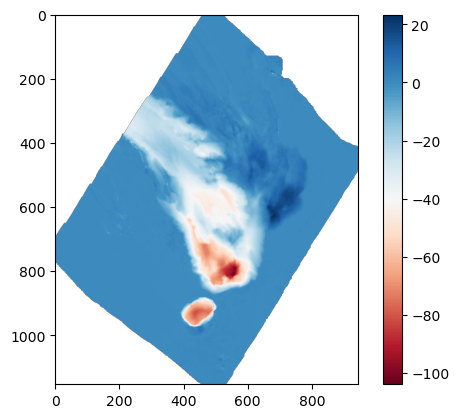

In [17]:
plt.imshow(als_diff, cmap='RdBu')
plt.colorbar()
plt.show()

In [18]:
als_diff_file = 'als_diff.tif'

with rio.open(als_diff_file, 'w', **dsm_meta) as ff:
    ff.write(als_diff, 1)

In [19]:
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.features import geometry_mask

# --- 1. Lade dein DoD Raster ---
with rasterio.open(als_diff_file) as src:
    dod = src.read(1)   # 2D Array
    profile = src.profile

# --- 2. Lade dein Polygon-Shapefile ---
gdf = gpd.read_file("data/stable_parts.shp")
gdf = gdf.to_crs(profile["crs"])   # sicherstellen, dass CRS übereinstimmt

# --- 3. Maske erzeugen ---
mask = geometry_mask(gdf.geometry, transform=profile["transform"],
                     invert=True, out_shape=(src.height, src.width))

# --- 4. Stable-Bereich extrahieren ---
stable_values = dod[mask]   # nur Pixel innerhalb der Polygone
stable_std = np.nanstd(stable_values)
lod = 1.96 * stable_std

print(f"Stable Std: {stable_std:.3f} m")
print(f"Estimated LoD: {lod:.3f} m")

stable_mean = np.nanmean(stable_values)
stable_median = np.nanmedian(stable_values)

print(f"Stable Mean: {stable_mean:.3f} m")
print(f"Stable Median: {stable_median:.3f} m")



Stable Std: 0.114 m
Estimated LoD: 0.223 m
Stable Mean: 0.185 m
Stable Median: 0.177 m


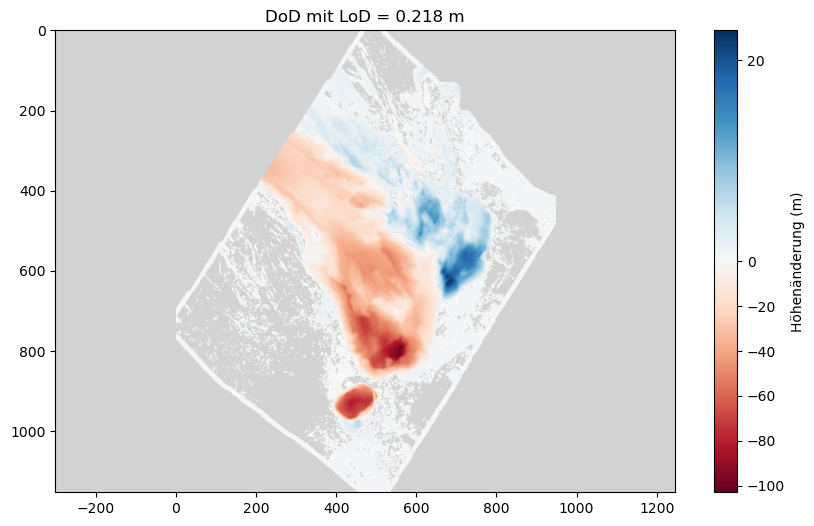

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

lod = 0.218  # LoD in Metern

# Maske für Werte unterhalb der LoD
mask = np.abs(uls_diff) < lod

# Maskierte Version für Plot
masked_diff = np.ma.array(als_diff, mask=mask)

# Colormap kopieren und maskierte Werte auf hellgrau setzen
cmap = plt.cm.RdBu.copy()
cmap.set_bad(color='lightgrey')  # Werte unter LoD werden grau

plt.figure(figsize=(10,6))
ax = plt.gca()
ax.set_facecolor('lightgrey')  # Hintergrund grau

# Symmetrische Farbskala um 0
max_abs = np.nanmax(np.abs(als_diff))
norm = mcolors.TwoSlopeNorm(vmin=-103, vcenter=0, vmax=23)

# Plotten
im = ax.imshow(masked_diff, cmap=cmap, norm=norm, origin='upper')
plt.colorbar(im, label='Höhenänderung (m)')
plt.title(f'DoD mit LoD = {lod:.3f} m')
plt.axis('equal')
plt.show()


In [21]:
print(f'Standard deviation of als surface change: {np.nanstd(als_diff):.3f} m')
print("DoD statistics (ignoring NaNs):")
print(f"Min change: {np.nanmin(als_diff):.3f} m")
print(f"Max change: {np.nanmax(als_diff):.3f} m")
print(f"Mean change: {np.nanmean(als_diff):.3f} m")
print(f"Median change: {np.nanmedian(als_diff):.3f} m")
print(f"Std deviation: {np.nanstd(als_diff):.3f} m")
print(f"Absolute mean change: {np.nanmean(np.abs(als_diff)):.3f} m")
print(f"RMS of change: {np.sqrt(np.nanmean(als_diff**2)):.3f} m\n")

print(f'Standard deviation of ULS surface change: {np.nanstd(uls_diff):.3f} m')
print("DoD statistics (ignoring NaNs):")
print(f"Min change: {np.nanmin(uls_diff):.3f} m")
print(f"Max change: {np.nanmax(uls_diff):.3f} m")
print(f"Mean change: {np.nanmean(uls_diff):.3f} m")
print(f"Median change: {np.nanmedian(uls_diff):.3f} m")
print(f"Std deviation: {np.nanstd(uls_diff):.3f} m")
print(f"Absolute mean change: {np.nanmean(np.abs(uls_diff)):.3f} m")
print(f"RMS of change: {np.sqrt(np.nanmean(uls_diff**2)):.3f} m")



Standard deviation of als surface change: 15.605 m
DoD statistics (ignoring NaNs):
Min change: -103.825 m
Max change: 23.327 m
Mean change: -6.095 m
Median change: -24.598 m
Std deviation: 15.605 m
Absolute mean change: 7.716 m
RMS of change: 16.753 m

Standard deviation of ULS surface change: 15.955 m
DoD statistics (ignoring NaNs):
Min change: -103.861 m
Max change: 23.145 m
Mean change: -6.378 m
Median change: -36.072 m
Std deviation: 15.955 m
Absolute mean change: 8.061 m
RMS of change: 17.182 m


c:\Users\Nutzer\miniforge3\envs\3D_analysis_norcia\Lib\site-packages\numpy\_core\fromnumeric.py:867: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [22]:
with rio.open(uls_diff_file) as src:
    uls_diff = src.read(1, masked=True)
    dsm_meta = src.profile

with rio.open(als_diff_file) as src:
    als_diff = src.read(1, masked=True)
    dsm_meta = src.profile

Text(0.5, 1.0, 'ALS Surface Change')

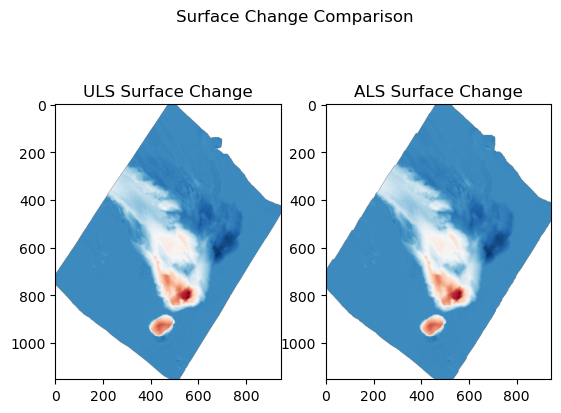

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Surface Change Comparison')

ax1.imshow(uls_diff, cmap='RdBu')
ax1.set_title('ULS Surface Change')
ax2.imshow(als_diff, cmap='RdBu')
ax2.set_title('ALS Surface Change')

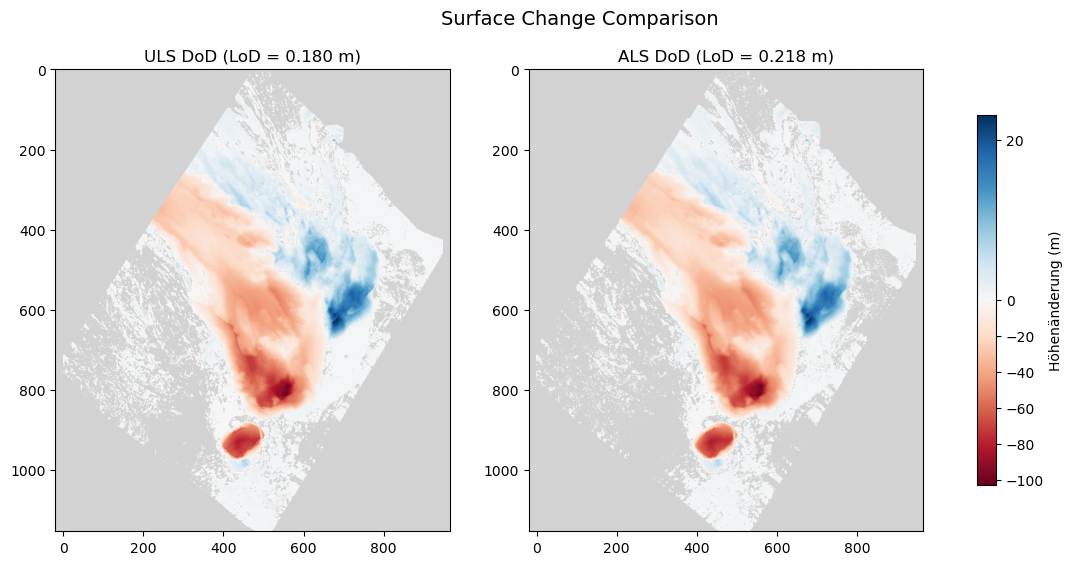

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# LoD-Werte
lod_uls = 0.180
lod_als = 0.218

# --- ULS ---
mask_uls = np.abs(uls_diff) < lod_uls
masked_uls = np.ma.array(uls_diff, mask=mask_uls)

# --- ALS ---
mask_als = np.abs(als_diff) < lod_als
masked_als = np.ma.array(als_diff, mask=mask_als)

# --- Farbskala ---
cmap = plt.cm.RdBu.copy()
cmap.set_bad(color='lightgrey')  # Maskierte Bereiche grau
norm = mcolors.TwoSlopeNorm(vmin=-103, vcenter=0, vmax=23)  # Symmetrisch um 0

# --- Figure ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Surface Change Comparison", fontsize=14)

# --- ULS ---
ax1.set_facecolor('lightgrey')
im1 = ax1.imshow(masked_uls, cmap=cmap, norm=norm, origin='upper')
ax1.set_title(f"ULS DoD (LoD = {lod_uls:.3f} m)")
ax1.axis('equal')

# --- ALS ---
ax2.set_facecolor('lightgrey')
im2 = ax2.imshow(masked_als, cmap=cmap, norm=norm, origin='upper')
ax2.set_title(f"ALS DoD (LoD = {lod_als:.3f} m)")
ax2.axis('equal')

# Gemeinsame Farbskala
cbar = fig.colorbar(im2, ax=[ax1, ax2], shrink=0.8, label="Höhenänderung (m)")

plt.show()


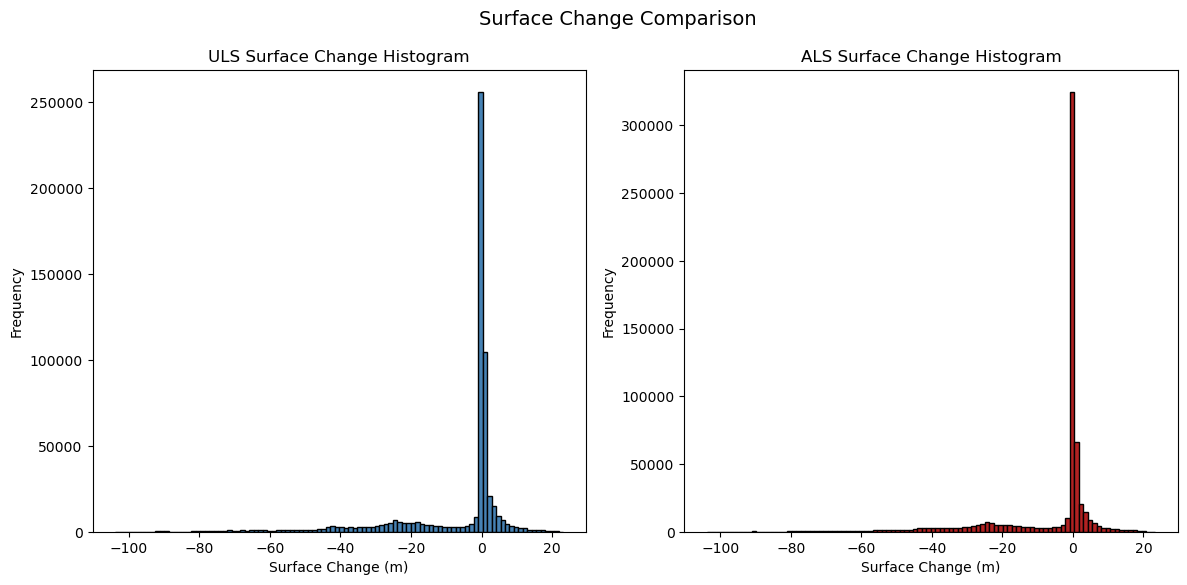

In [25]:
# plot histogram of uls and als change detections
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Surface Change Comparison", fontsize=14)
# --- ULS ---
ax1.hist(uls_diff.compressed(), bins=100, color='steelblue', edgecolor='black')
ax1.set_title('ULS Surface Change Histogram')
ax1.set_xlabel('Surface Change (m)')
ax1.set_ylabel('Frequency')
# --- ALS ---  
ax2.hist(als_diff.compressed(), bins=100, color='firebrick', edgecolor='black')
ax2.set_title('ALS Surface Change Histogram')
ax2.set_xlabel('Surface Change (m)')
ax2.set_ylabel('Frequency')
plt.show()


In [26]:
change_det_diff = uls_diff - als_diff

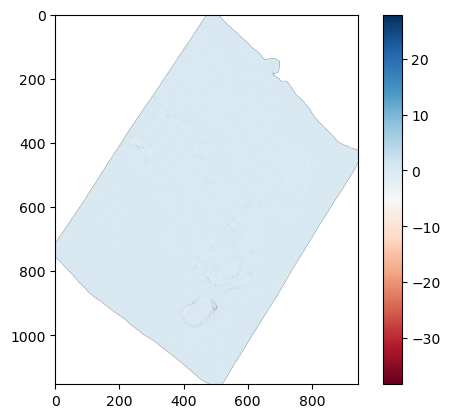

In [27]:
plt.imshow(change_det_diff, cmap='RdBu')
plt.colorbar()
plt.show()

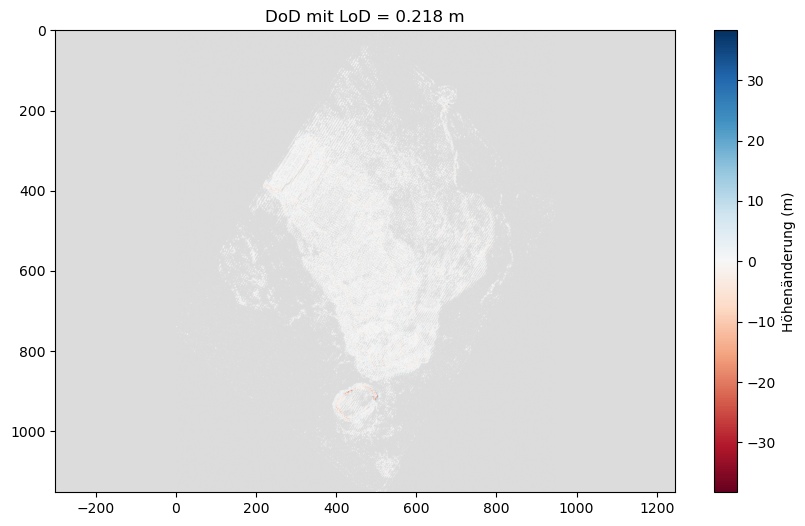

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

lod = 0.218  # LoD in Metern

# Maske für Werte unterhalb der LoD
mask = np.abs(change_det_diff) < lod

# Maskierte Version für den Plot
masked_diff = np.ma.array(change_det_diff, mask=mask)

# Colormap kopieren und maskierte Werte auf hellgrau setzen
cmap = plt.cm.RdBu.copy()
cmap.set_bad(color='gainsboro')  # Werte unter LoD werden grau

plt.figure(figsize=(10,6))
ax = plt.gca()
ax.set_facecolor('gainsboro')  # Hintergrund grau

# Farbskala symmetrisch um 0 setzen
max_abs = np.nanmax(np.abs(change_det_diff))
norm = mcolors.TwoSlopeNorm(vmin=-max_abs, vcenter=0, vmax=max_abs)

# Plotten
im = ax.imshow(masked_diff, cmap=cmap, norm=norm, origin='upper')
plt.colorbar(im, label='Höhenänderung (m)')
plt.title(f'DoD mit LoD = {lod:.3f} m')
plt.axis('equal')
plt.show()


Next, we can calculate some statistics for the differences between the ULS and ALS change detection.

In [32]:
print(f'Maximum difference in detected surface change: {np.nanmax(np.abs(change_det_diff)):.3f} m')
print(f'Median absolute difference in detected surface change: {np.nanmedian(np.abs(change_det_diff)):.3f} m')
print(f'Arithmetic mean of absolute difference in detected surface change: {np.nanmean(np.abs(change_det_diff)):.3f} m')
print(f'Median of difference in detected surface change: {np.nanmedian(change_det_diff):.3f} m')
print(f'Standard deviation of difference in detected surface change: {np.nanstd(change_det_diff):.3f} m')



Maximum difference in detected surface change: 38.259 m
Median absolute difference in detected surface change: 0.866 m
Arithmetic mean of absolute difference in detected surface change: 0.256 m
Median of difference in detected surface change: -0.492 m
Standard deviation of difference in detected surface change: 0.654 m


As we can see, small overall differences in the detected magnitude do exist between the ALS and ULS surface change detection.

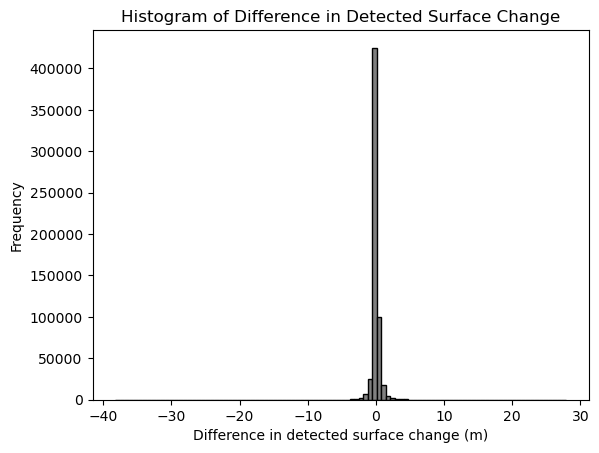

In [30]:
# plot histrogram of change_det_diff
plt.hist(change_det_diff.compressed(), bins=100, color='gray', edgecolor='black')
plt.xlabel('Difference in detected surface change (m)')
plt.ylabel('Frequency')
plt.title('Histogram of Difference in Detected Surface Change')
plt.show()

### 5. Results

<details>
    <summary>
        <b>Answer the following questions:</b> <br>
        1. Is ALS data sufficient for conducting our surface change analysis?
        <br>
        2. Repeat: What is the advantage of conducting ALS vs. ULS acquisitions?
        <br>
    Have another look at the plots and the statistics and try to answer the questions. For our answer, click on this text.
    </summary>
  
  ### Answer
  We found that the lower density point clouds from ALS provided a similar amount of information about the **areas** of surface change but yielded slightly higher inaccuracies regarding the **magnitudes** of surface change. We can therefore conclude that lower point density point clouds, such as those delivered by ALS acquisitions of the rock glacier, would be sufficient to **detect the areas** where surface change has occurred, whereas ULS data with higher spatial resolution would be required to accurately **measure the magnitudes** of the change. Because ALS acquisitions can cover **larger areas** than ULS, and because ALS data are increasingly available online through **national inventory databases**, ALS can be a **cost-effective** data source, especially for monitoring large study sites. For **smaller study sites** requiring **high resolution** data with potentially **specific acquisition setups** and **short acquisition intervals**, ULS will be the acquisition method of choice.

In addition, we have to take into account that some of the differences between the surface change derived from simulated ALS data and real-world ULS data can also be attributed to errors introduced during the DTM generation and LiDAR simulation steps.
</details>

**Bonus questions:**

1. Can you think of other methods of surface change detection?
2. Do you think ALS point clouds would be sufficient for these methods?